# Plot citation statistics for CMIP overview publications

In [46]:
# Updates
# PJD  5 Apr 2023 - Started
# PJD 13 Apr 2023 - Updated citation counts
# PJD 14 Apr 2023 - Augmented to include comparison models (CCSM4, CESM1, CESM2, E3SM-1-0)
# PJD 14 Apr 2023 - Augmented to consider all CMIP6 MIP papers
# PJD 12 Jul 2023 - Add CDRMIP durack1/MIPPlots#1; update all entries
# PJD 12 Jul 2023 - Add Charney 1979 and FANGIO/Cess 1990 durack1/MIPPlots#2

## imports

In [47]:
import matplotlib.pyplot as plt
import numpy as np
import copy
import datetime
import os

## define time info

In [48]:
timeNow = datetime.datetime.now()
timeFormat = timeNow.strftime("%y%m%dT%H%M%S")
print("timeFormat:", timeFormat)

timeFormat: 230712T065308


## define input data

In [49]:
labels = ["AMIP1", "CMIP1", "CMIP2", "CMIP3", "CMIP5", "CMIP6", "CMIP6Composite"]

# Charney National Research Council, 1979 National Academies Press
# 1979 - 2023
# https://doi.org/10.17226/12181
# https://scholar.google.com/scholar?cluster=15553179873625400927&hl=en&as_sdt=0,5, 663 google scholar
charneyGS = 663

# FANGIO Cess et al., 1990 JGR
# 1991 - 2023 https://www.webofscience.com/wos/woscc/full-record/WOS:A1990EB20200022, 725 web of science
# https://doi.org/10.1029/JD095iD10p16601
# https://scholar.google.com/scholar?cluster=6135992129360534519&hl=en&as_sdt=0,5, 1075 google scholar
fangio = [11, 22, 24, 31, 33, 33, 37, 21, 31, 21, 21, 11, 13, 15, 23, 28, 22, 30, 14, 22, 16, 22,
          20, 27, 21, 19, 23, 18, 27, 19, 26, 12, 9]

# create pad index - based on longest citation length (FANGIO, 1991-)
pad = [np.nan]*len(fangio)
# Year since publication
yrSincePublication = np.arange(0, len(fangio))

# AMIP1 Gates et al., 1992 BAMS
# 1992, 1993 - 2023 https://www.webofscience.com/wos/woscc/full-record/WOS:A1992KD66500003
# https://doi.org/10.1175/1520-0477(1992)073<1962:ATAMIP>2.0.CO;2
amip1 = [0, 1, 18, 50, 54, 60, 67, 60, 60, 39, 38, 48, 23, 22, 23, 21, 20, 14, 17, 21, 16,
        21, 25, 27, 33, 22, 27, 27, 25, 23, 21, 13]
amip1a = copy.deepcopy(pad)
amip1a[:len(amip1)] = amip1
amip1 = amip1a
del(amip1a)

# CMIP1 Meehl et al., 1995 BAMS
# 1995, 1996 - 2023 https://www.webofscience.com/wos/woscc/full-record/WOS:A1995RG21000008
# https://doi.org/10.1175/1520-0477-76.6.951
cmip1 = [0, 3, 6, 5, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 4, 3, 4]
cmip1a = copy.deepcopy(pad)
cmip1a[:len(cmip1)] = cmip1
cmip1 = cmip1a
del(cmip1a)

# CMIP2 Meehl et al., 2005 BAMS
# 2005 - 2023 https://www.webofscience.com/wos/woscc/full-record/WOS:000226970100024, 237 web of science
# https://doi.org/10.1175/BAMS-86-1-89
# https://scholar.google.com/scholar?cluster=414872318861866058&hl=en&as_sdt=0,5, 349 google scholar
cmip2 = [5, 5, 7, 12, 12, 7, 15, 18, 21, 18, 21, 16, 11, 7, 10, 22, 13, 10, 6]
cmip2a = copy.deepcopy(pad)
cmip2a[:len(cmip2)] = cmip2
cmip2 = cmip2a
del(cmip2a)

# CMIP3 Meehl et al., 2007 BAMS - 230413 - 2175 Web of Science; 3272 Google Scholar
# 2007 - 2023 https://www.webofscience.com/wos/woscc/full-record/WOS:000250166400004, 2193 web of science
# https://doi.org/10.1175/BAMS-88-9-1383
# https://scholar.google.com/scholar?cluster=10102268002781422381&hl=en&as_sdt=0,5, 3299 google scholar
cmip3 = [3, 28, 100, 131, 188, 265, 315, 206, 187, 145, 121, 104, 87, 108, 69, 66, 29]
cmip3a = copy.deepcopy(pad)
cmip3a[:len(cmip3)] = cmip3
cmip3 = cmip3a
del(cmip3a)

# CMIP5 Taylor et al., 2012 BAMS
# 2012 - 2023 https://www.webofscience.com/wos/woscc/full-record/WOS:000303110900004, 10271 web of science
# https://doi.org/10.1175/BAMS-D-11-00094.1
# https://scholar.google.com/scholar?cluster=6589368678432360376&hl=en&as_sdt=0,5, 13902 google scholar
cmip5 = [98, 503, 619, 838, 919, 1011, 1250, 1290, 1250, 1178, 877, 302]
cmip5a = copy.deepcopy(pad)
cmip5a[:len(cmip5)] = cmip5
cmip5 = cmip5a
del(cmip5a)
cmip5GS = 13902

# CMIP6 Eyring et al., 2016 GMD - 230413 - 3372 Web of Science; 4834 Google Scholar
# 2016 - 2023 https://www.webofscience.com/wos/woscc/full-record/WOS:000376937800013, 3746 web of science
# https://doi.org/10.5194/gmd-9-1937-2016
# https://scholar.google.com/scholar?cluster=5319430665468485905&hl=en&as_sdt=0,5, 5250 google scholar
cmip6 = [23, 58, 112, 155, 544, 927, 1300, 622]
cmip6a = copy.deepcopy(pad)
cmip6a[:len(cmip6)] = cmip6
cmip6 = cmip6a
del(cmip6a)
cmip6GS = 5250

# CMIP6 MIPs - https://gmd.copernicus.org/articles/special_issue590.html + CDRMIP
# 2016 - 2023
# aerchemmip - Collins et al., 2017
# 2017 - 2023 https://www.webofscience.com/wos/woscc/full-record/WOS:000395391000001
# https://doi.org/10.5194/gmd-10-585-2017
aerchemmip = [np.nan, 5, 14, 14, 32, 21, 41, 10]
# c4mip - Jones et al., 2016
# 2016 - 2023 https://www.webofscience.com/wos/woscc/full-record/WOS:000383844500002
# https://doi.org/10.5194/gmd-9-2853-2016
c4mip = [2, 6, 7, 16, 34, 32, 31, 10]
# cdrmip - Keller et al., 2018
# 2016 - 2023 https://www.webofscience.com/wos/woscc/full-record/WOS:000428836100001
# https://doi.org/10.5194/gmd-11-1133-2018
cdrmip = [np.nan, np.nan, 7, 6, 14, 14, 21, 9]
# cfmip - Webb et al., 2017
# 2016 - 2023 https://www.webofscience.com/wos/woscc/full-record/WOS:000395187500001
# https://doi.org/10.5194/gmd-10-359-2017
cfmip = [3, 12, 18, 25, 32, 24, 24, 15]
# cordex - Gutowski et al., 2016
# 2016 - 2023 https://www.webofscience.com/wos/woscc/full-record/WOS:000387989000001
# https://doi.org/10.5194/gmd-9-4087-2016
cordex = [1, 6, 19, 30, 45, 48, 44, 22]
# damip - Gillett et al., 2016
# 2016 - 2023 https://www.webofscience.com/wos/woscc/full-record/WOS:000386585100001
# https://doi.org/10.5194/gmd-9-3685-2016
damip = [np.nan, 3, 5, 14, 22, 48, 70, 25]
# dcpp - Boer et al., 2016
# 2016 - 2023 https://www.webofscience.com/wos/woscc/full-record/WOS:000387064200001
# https://doi.org/10.5194/gmd-9-3751-2016
dcpp = [7, 14, 10, 37, 45, 41, 42, 21]
# dynvarmip - Gerber & Manzini, 2016
# 2016 - 2023 https://www.webofscience.com/wos/woscc/full-record/WOS:000384624000001
# https://doi.org/10.5194/gmd-9-3413-2016
dynvarmip = [np.nan, np.nan, 1, 3, 10, 3, 5, np.nan]
# fafmip - Gregory et al., 2016
# 2016 - 2023 https://www.webofscience.com/wos/woscc/full-record/WOS:000387988500001
# https://doi.org/10.5194/gmd-9-3993-2016
fafmip = [np.nan, 3, 10, 15, 26, 11, 25, 10]
# geomip6 - Kravitz et al., 2015
# 2015 - 2023 https://www.webofscience.com/wos/woscc/full-record/WOS:000364326200024
# https://doi.org/10.5194/gmd-8-3379-2015
geomip6 = [2+10, 7, 19, 10, 12, 11, 21, 15]
# gmmip - Zhou et al., 2016
# 2016 - 2023 https://www.webofscience.com/wos/woscc/full-record/WOS:000385387800001
# https://doi.org/10.5194/gmd-9-3589-2016
gmmip = [2, np.nan, 2, 12, 15, 14, 9, 9]
# highresmip - Haarsma et al., 2016
# 2016 - 2023 https://www.webofscience.com/wos/woscc/full-record/WOS:000388191000002
# https://doi.org/10.5194/gmd-9-4185-2016
highresmip = [5, 19, 28, 65, 104, 119, 107, 51]
# ismip6 - Nowicki et al., 2016
# 2016 - 2023 https://www.webofscience.com/wos/woscc/full-record/WOS:000391579600002
# https://doi.org/10.5194/gmd-9-4521-2016
ismip6 = [3, 13, 15, 22, 36, 22, 16, 8]
# ls3mip - van den Hurk et al., 2016
# 2016 - 2023 https://www.webofscience.com/wos/woscc/full-record/WOS:000383800400002
# https://doi.org/10.5194/gmd-9-2809-2016
ls3mip = [1, 13, 16, 17, 17, 24, 20, 10]
# lumip - Lawrence et al., 2016
# 2016 - 2023 https://www.webofscience.com/wos/woscc/full-record/WOS:000383892800002
# https://doi.org/10.5194/gmd-9-2973-2016
lumip = [7, 18, 31, 26, 50, 47, 52, 20]
# omip1 - Griffies et al., 2016
# 2016 - 2023 https://www.webofscience.com/wos/woscc/full-record/WOS:000384321500001
# https://doi.org/10.5194/gmd-9-3231-2016
omip1 = [3, 9, 15, 16, 32, 32, 40, 23]
# omip2 - Orr et al., 2017
# 2017 - 2023 https://www.webofscience.com/wos/woscc/full-record/WOS:000403231800001
# https://doi.org/10.5194/gmd-10-2169-2017
omip2 = [2, 4, 6, 20, 24, 25, 26, 5]
# pamip - Smith et al., 2019
# 2019 - 2023 https://www.webofscience.com/wos/woscc/full-record/WOS:000462352700002
# https://doi.org/10.5194/gmd-12-1139-2019
pamip = [np.nan, np.nan, 1, 8, 27, 40, 36, 19]
# pmip4 - Kageyama et al., 2018
# 2018 - 2023 https://www.webofscience.com/wos/woscc/full-record/WOS:000427841800004
# https://doi.org/10.5194/gmd-11-1033-2018
pmip4 = [np.nan, np.nan, 9, 19, 30, 23, 32, 14]
# rfmip - Pincus et al., 2016
# 2016 - 2023 https://www.webofscience.com/wos/woscc/full-record/WOS:000385385300001
# https://doi.org/10.5194/gmd-9-3447-2016
rfmip = [1, 8, 6, 19, 34, 33, 29, 10]
# scenariomip - O'Neill et al., 2016
# 2016 - 2023 https://www.webofscience.com/wos/woscc/full-record/WOS:000385385700001
# https://doi.org/10.5194/gmd-9-3461-2016
scenariomip = [6, 13, 15, 32, 157, 331, 536, 258]
# simip - Notz et al., 2016
# 2016 - 2023 https://www.webofscience.com/wos/woscc/full-record/WOS:000384624000002
# https://doi.org/10.5194/gmd-9-3427-2016
simip = [np.nan, 5, 5, 6, 17, 10, 10, 7]
# viacsab - Ruane et al., 2016
# 2016 - 2023 https://www.webofscience.com/wos/woscc/full-record/WOS:000385386000002
# https://doi.org/10.5194/gmd-9-3493-2016
viacsab = [2, 3, 4, 6, 6, 5, 4, np.nan]
# volmip - Zanchettin et al., 2016
# 2016 - 2023 https://www.webofscience.com/wos/woscc/full-record/WOS:000383794200001
# https://doi.org/10.5194/gmd-9-2701-2016
volmip = [7, 14, 10, 19, 20, 19, 15, 12]
# zecmip - Jones et al., 2019
# # 2019 - 2023 https://www.webofscience.com/wos/woscc/full-record/WOS:000490550000001
# https://doi.org/10.5194/gmd-12-4375-2019
zecmip = [np.nan, np.nan, np.nan, 1, 10, 10, 12, 2]

# E3SM-1-0 Golaz et al., 2019 JAMES
# 2019 - 2023 https://www.webofscience.com/wos/woscc/full-record/WOS:000480282800012
# https://doi.org/10.1029/2018MS001603
# https://doi.org/10.1029/2019MS001870 - Caldwell et al., 2019 high resolution ~74 citations
e3sm1_0 = [30, 74, 79, 79, 35]
e3sm1_0a = copy.deepcopy(pad)
e3sm1_0a[:len(e3sm1_0)] = e3sm1_0
e3sm1_0 = e3sm1_0a
del(e3sm1_0a)

# E3SM-2-0 Golaz et al., 2022 JAMES
# 2022-2023 https://www.webofscience.com/wos/woscc/full-record/WOS:000924492900001
# https://doi.org/10.1029/2022MS003156
#e3sm2_0 = [3, 7]

# CCSM4 Gent et al., 2011 JCL
# 2011 - 2023 https://www.webofscience.com/wos/woscc/full-record/WOS:000295905400001
# https://doi.org/10.1175/2011JCLI4083.1
ccsm4 = [9, 84, 152, 181, 173, 221, 194, 213, 225, 217, 191, 160, 59]
ccsm4a = copy.deepcopy(pad)
ccsm4a[:len(ccsm4)] = ccsm4
ccsm4 = ccsm4a
del(ccsm4a)

# CESM1 Hurrell et al., 2013 BAMS
# 2013 - 2023 https://www.webofscience.com/wos/woscc/full-record/WOS:000325135100007
# https://doi.org/10.1175/BAMS-D-12-00121.1
cesm1 = [3, 46, 68, 126, 161, 212, 238, 257, 259, 222, 100]
cesm1a = copy.deepcopy(pad)
cesm1a[:len(cesm1)] = cesm1
cesm1 = cesm1a
del(cesm1a)

# CESM2 Danabasoglu et al., 2020 JAMES
# 2020 - 2023 https://www.webofscience.com/wos/woscc/full-record/WOS:000519728500010
# https://doi.org/10.1029/2019MS001916
cesm2 = [79, 176, 248, 131]
cesm2a = copy.deepcopy(pad)
cesm2a[:len(cesm2)] = cesm2
cesm2 = cesm2a
del(cesm2a)

# Prints
print("Grey literature uptick? (Google Scholar/Web of Science)")
print("Taylor et al., 2012:", cmip5GS/np.nansum(cmip5))
print("Eyring et al., 2016:", cmip6GS/np.nansum(cmip6))
print()
print("yrSincePublication:", yrSincePublication)
print("fangio:", fangio)
print("amip1:", amip1)
print("cmip1:", cmip1)
print("cmip2:", cmip2)
print("cmip3:", cmip3)
print("cmip5:", cmip5)
print("cmip6:", cmip6)

Grey literature uptick? (Google Scholar/Web of Science)
Taylor et al., 2012: 1.371682289097188
Eyring et al., 2016: 1.4033680834001603

yrSincePublication: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32]
fangio: [11, 22, 24, 31, 33, 33, 37, 21, 31, 21, 21, 11, 13, 15, 23, 28, 22, 30, 14, 22, 16, 22, 20, 27, 21, 19, 23, 18, 27, 19, 26, 12, 9]
amip1: [0, 1, 18, 50, 54, 60, 67, 60, 60, 39, 38, 48, 23, 22, 23, 21, 20, 14, 17, 21, 16, 21, 25, 27, 33, 22, 27, 27, 25, 23, 21, 13]
cmip1: [0, 3, 6, 5, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 4, 3, 4, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
cmip2: [5, 5, 7, 12, 12, 7, 15, 18, 21, 18, 21, 16, 11, 7, 10, 22, 13, 10, 6, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
cmip3: [3, 28, 100, 131, 188, 265, 315, 206, 187, 145, 121, 104, 87, 108, 69, 66, 29, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
cmip5: [98, 503, 619,

## first plot - MIPs only

ValueError: x and y must have same first dimension, but have shapes (33,) and (32,)

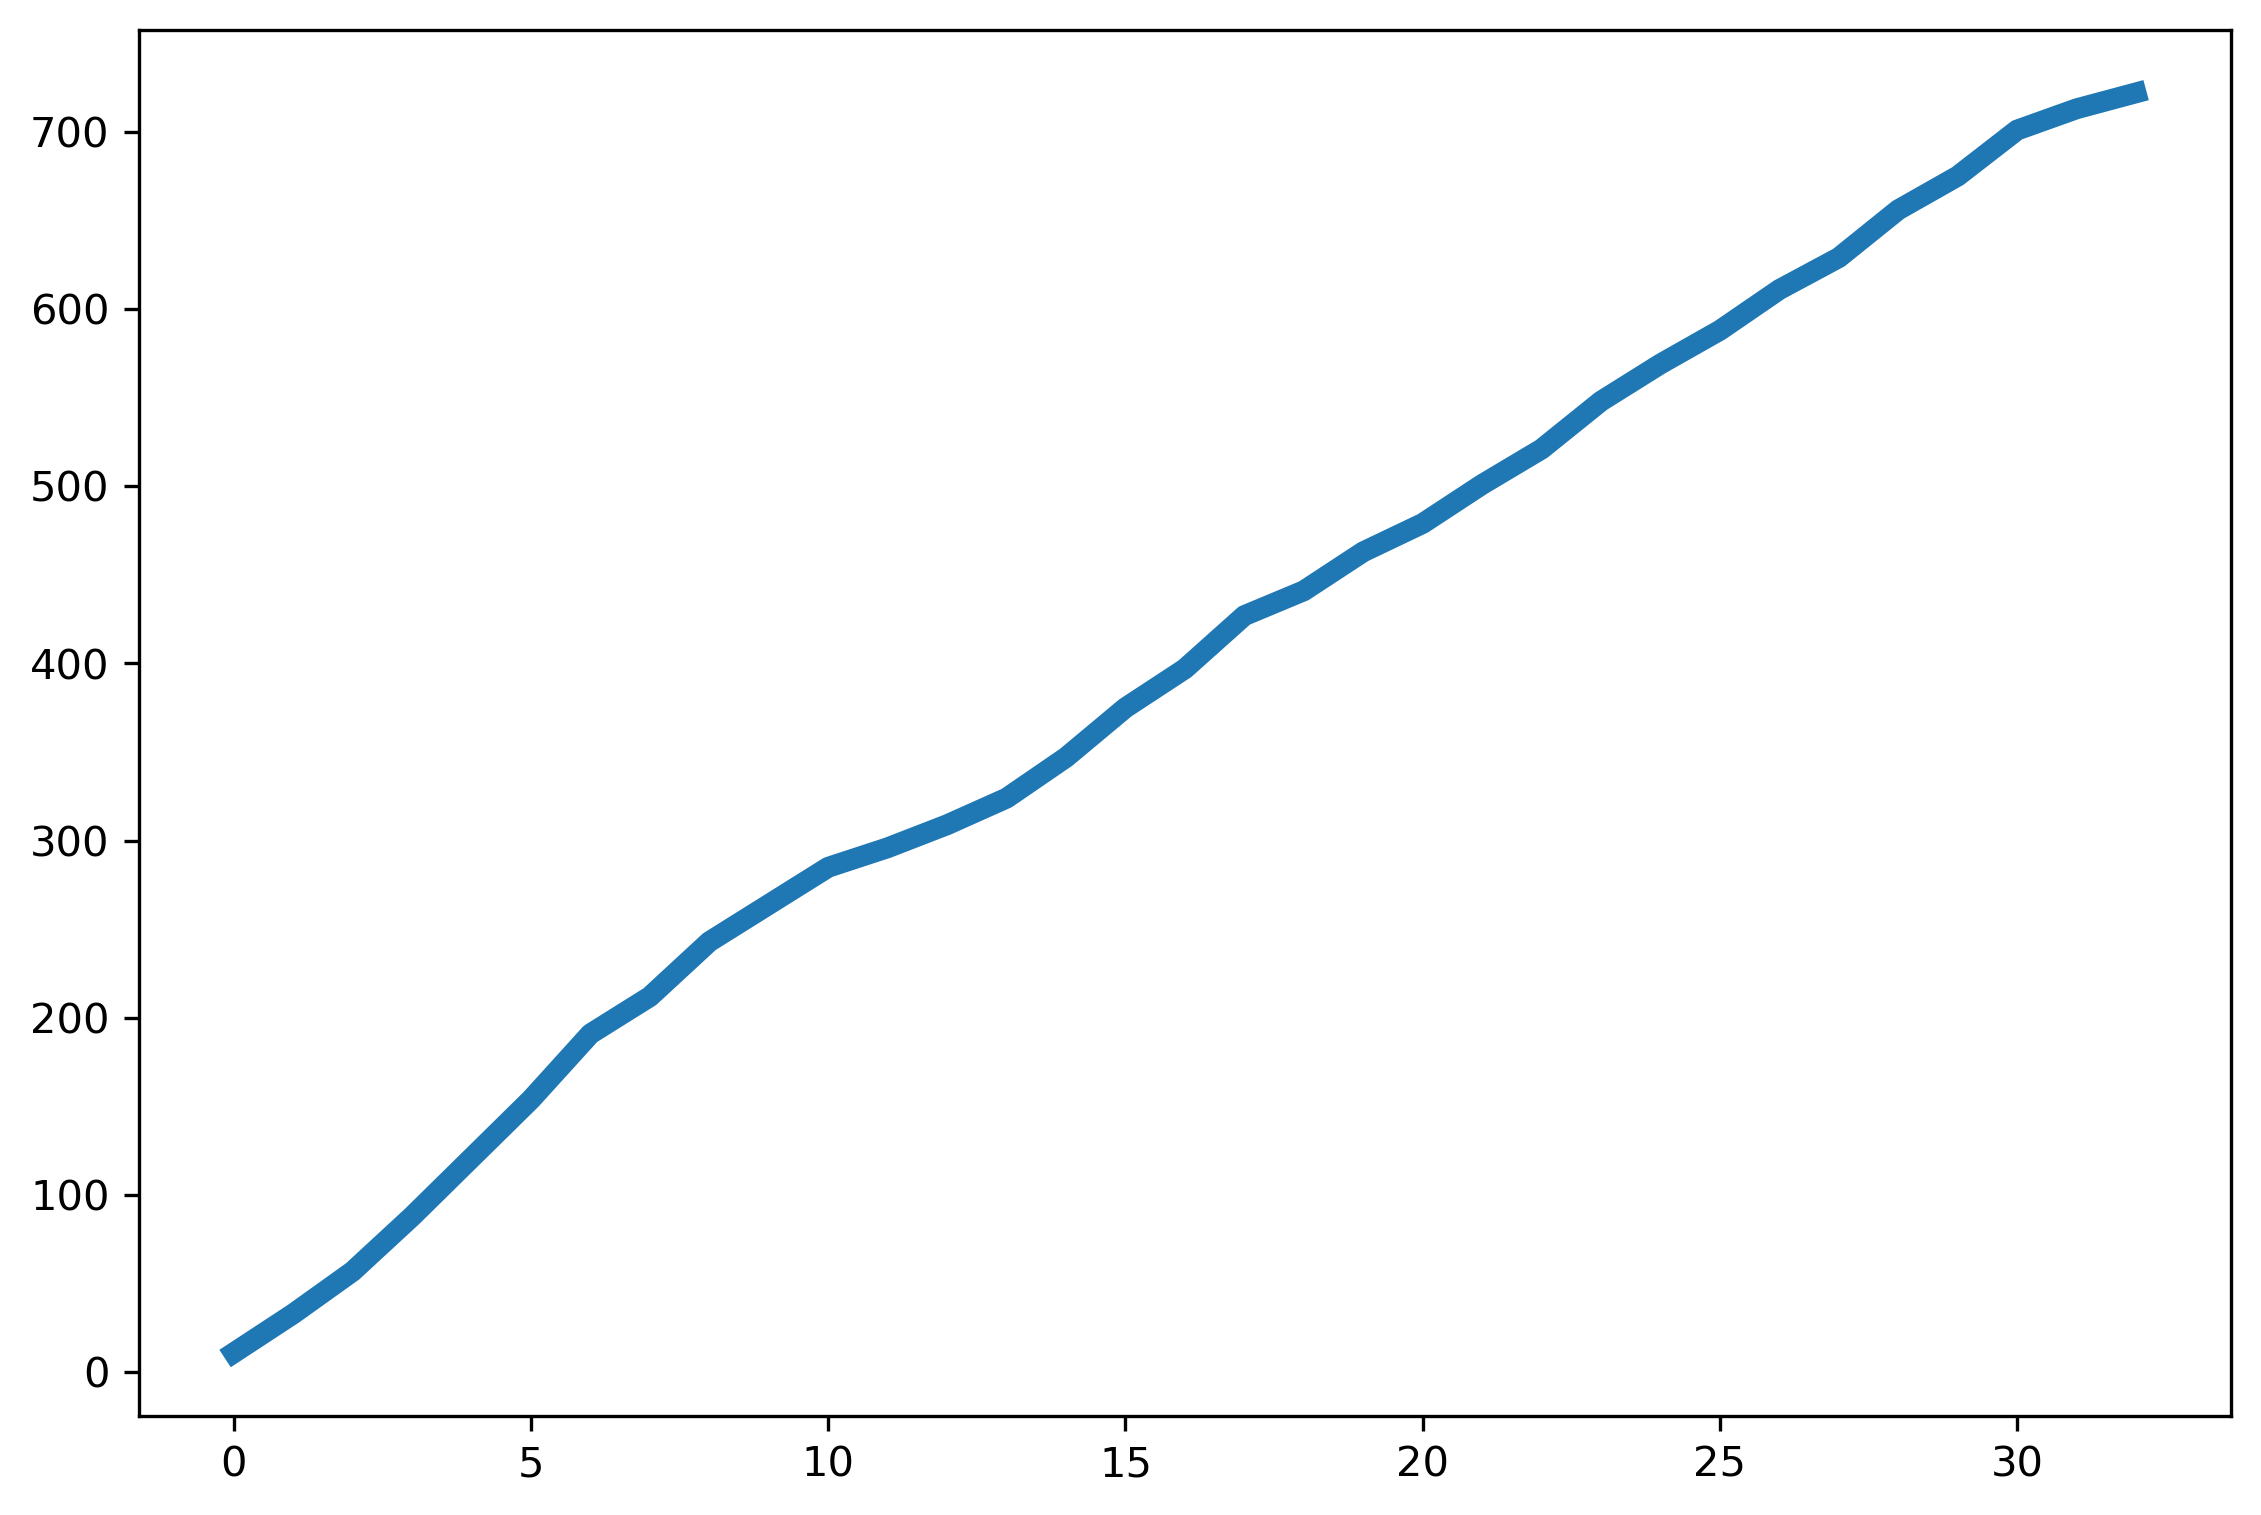

In [50]:
# set inputs
x = np.arange(len(labels))  # label locations
width = 0.25  # width of the bars
fontsize = 14
lineWidth = 5
fontName = "Microsoft Sans Serif"

# initialize canvas
fig, ax = plt.subplots(figsize=(9, 6), dpi=300)

# plot from year 1
line0 = plt.plot(yrSincePublication, np.cumsum(fangio), linewidth=lineWidth, label="FANGIO (Cess et al., 1990)")
line1 = plt.plot(yrSincePublication, np.cumsum(amip1), linewidth=lineWidth, label="AMIP1 (Gates et al., 1992)")
line2 = plt.plot(yrSincePublication, np.cumsum(cmip1), linewidth=lineWidth, label="CMIP1 (Meehl et al., 1995)")
line3 = plt.plot(yrSincePublication, np.cumsum(cmip2), linewidth=lineWidth, label="CMIP2 (Meehl et al., 2005)")
line4 = plt.plot(yrSincePublication, np.cumsum(cmip3), linewidth=lineWidth, label="CMIP3 (Meehl et al., 2007)")
line5 = plt.plot(yrSincePublication, np.cumsum(cmip5), linewidth=lineWidth, label="CMIP5 (Taylor et al., 2012)")
line6 = plt.plot(yrSincePublication, np.cumsum(cmip6), linewidth=lineWidth, label="CMIP6 (Eyring et al., 2016)")
star0 = plt.plot(2023-1979, charneyGS, marker="*", markersize=16, linestyle="None", label="US Nat. Res. Counc. (Charney et al., 1979)")

# pretty things up - add text for labels, title and custom x-axis tick labels, etc.
ax.set_title('*MIP Overview Paper Citation Counts since Publication (annual to 2023)',
             fontname=fontName, fontsize=fontsize)
ax.set_ylabel('Citation Count', fontname=fontName, fontsize=fontsize)
plt.yticks(fontname=fontName, fontsize=fontsize)
ax.set_xlabel("Years since Publication", fontname=fontName, fontsize=fontsize)
plt.xticks(fontname=fontName, fontsize=fontsize)
ax.legend(prop={"family": fontName, "size": fontsize})

# fill canvas
fig.tight_layout()

# display, save and close
plt.show()
fig.savefig("_".join([timeFormat, "CMIPOverviewPaperCitations-Counts.png"]))

## second plot - MIPs and composite CMIP6

In [ ]:
# Generate composite CMIP6
cmip6Comp = np.nansum([aerchemmip, c4mip, cdrmip, cfmip, cordex, damip, dcpp, dynvarmip, fafmip, geomip6, gmmip,
                       highresmip, ismip6, ls3mip, lumip, omip1, omip2, pamip, pmip4, rfmip, scenariomip,
                       simip, viacsab, volmip, zecmip], 0)
cmip6Compa = copy.deepcopy(pad)
cmip6Compa[:len(cmip6Comp)] = cmip6Comp
cmip6Comp = cmip6Compa
del(cmip6Compa)
cmip6CompA = np.nansum([cmip6, cmip6Comp], 0)
cmip6CompA = np.where(cmip6CompA == 0., np.nan, cmip6CompA)

# set inputs
x = np.arange(len(labels))  # label locations
width = 0.25  # width of the bars
fontsize = 14
lineWidth = 5
fontName = "Microsoft Sans Serif"

# initialize canvas
fig, ax = plt.subplots(figsize=(9, 6), dpi=300)

# plot from year 1
line0 = plt.plot(yrSincePublication, np.cumsum(fangio), linewidth=lineWidth, label="FANGIO (Cess et al., 1990)")
line1 = plt.plot(yrSincePublication, np.cumsum(amip1), linewidth=lineWidth, label="AMIP1 (Gates et al., 1992)")
line2 = plt.plot(yrSincePublication, np.cumsum(cmip1), linewidth=lineWidth, label="CMIP1 (Meehl et al., 1995)")
line3 = plt.plot(yrSincePublication, np.cumsum(cmip2), linewidth=lineWidth, label="CMIP2 (Meehl et al., 2005)")
line4 = plt.plot(yrSincePublication, np.cumsum(cmip3), linewidth=lineWidth, label="CMIP3 (Meehl et al., 2007)")
line5 = plt.plot(yrSincePublication, np.cumsum(cmip5), linewidth=lineWidth, label="CMIP5 (Taylor et al., 2012)")
line6 = plt.plot(yrSincePublication, np.cumsum(cmip6), linewidth=lineWidth, label="CMIP6 (Eyring et al., 2016)")
line7 = plt.plot(yrSincePublication, np.cumsum(cmip6Comp), linewidth=lineWidth, label="CMIP6 (Satellite MIPs 2015-)")
line8 = plt.plot(yrSincePublication, np.cumsum(cmip6CompA), linewidth=lineWidth, label="CMIP6 (Composite 2015-)")
star0 = plt.plot(2023-1979, charneyGS, marker="*", markersize=16, linestyle="None", label="US Nat. Res. Counc. (Charney et al., 1979)")

# pretty things up - add text for labels, title and custom x-axis tick labels, etc.
ax.set_title('*MIP Overview Paper Citation Counts since Publication (annual to 2023)',
             fontname=fontName, fontsize=fontsize)
ax.set_ylabel('Citation Count', fontname=fontName, fontsize=fontsize)
plt.yticks(fontname=fontName, fontsize=fontsize)
ax.set_xlabel("Years since Publication", fontname=fontName, fontsize=fontsize)
plt.xticks(fontname=fontName, fontsize=fontsize)
ax.legend(prop={"family": fontName, "size": fontsize})

# fill canvas
fig.tight_layout()

# display, save and close
plt.show()
fig.savefig("_".join([timeFormat, "CMIPOverviewPaperCitations-Counts-2.png"]))

# third plot - MIPs + CCSM4, CESM1, CESM2, E3SM-1-0

In [ ]:
# set inputs
x = np.arange(len(labels))  # label locations
width = 0.25  # width of the bars
fontsize = 14
lineWidth = 5
fontName = "Microsoft Sans Serif"

# initialize canvas
fig, ax = plt.subplots(figsize=(9, 6), dpi=300)

# plot from year 1
line0, = plt.plot(yrSincePublication, np.cumsum(fangio), linewidth=lineWidth)
line1, = plt.plot(yrSincePublication, np.cumsum(amip1), linewidth=lineWidth)
line2, = plt.plot(yrSincePublication, np.cumsum(cmip1), linewidth=lineWidth)
line3, = plt.plot(yrSincePublication, np.cumsum(cmip2), linewidth=lineWidth)
line4, = plt.plot(yrSincePublication, np.cumsum(cmip3), linewidth=lineWidth)
line5, = plt.plot(yrSincePublication, np.cumsum(cmip5), linewidth=lineWidth)
line6, = plt.plot(yrSincePublication, np.cumsum(cmip6), linewidth=lineWidth)
line7, = plt.plot(yrSincePublication, pad, color="w")
line8, = plt.plot(yrSincePublication, np.cumsum(ccsm4), linewidth=lineWidth)
line9, = plt.plot(yrSincePublication, np.cumsum(cesm1), linewidth=lineWidth)
line10, = plt.plot(yrSincePublication, np.cumsum(cesm2), linewidth=lineWidth)
line11, = plt.plot(yrSincePublication, np.cumsum(e3sm1_0), linewidth=lineWidth)
line12, = plt.plot(yrSincePublication, pad, color="w")
star0, = plt.plot(2023-1979, charneyGS, marker="*", markersize=16, linestyle="None")

# pretty things up - add text for labels, title and custom x-axis tick labels, etc.
ax.set_title('*MIP Overview and Model Paper Citation Counts since Publication (annual to 2023)',
             fontname=fontName, fontsize=fontsize)
ax.set_ylabel('Citation Count', fontname=fontName, fontsize=fontsize)
plt.yticks(fontname=fontName, fontsize=fontsize)
ax.set_xlabel("Years since Publication", fontname=fontName, fontsize=fontsize)
plt.xticks(fontname=fontName, fontsize=fontsize)
ax.legend((line0, line1, line2, line3, line4, line5, line6, line7, line8, line9, line10, line11, line12, star0),
          ("FANGIO (Cess et al., 1990)", "AMIP1 (Gates et al., 1992)", "CMIP1 (Meehl et al., 1995)",
           "CMIP2 (Meehl et al., 2005)", "CMIP3 (Meehl et al., 2007)", "CMIP5 (Taylor et al., 2012)",
           "CMIP6 (Eyring et al., 2016)", "", "CCSM4 (Gent et al., 2011)",
           "CESM1 (Hurrell et al., 2013)", "CESM2 (Danabasoglu et al., 2020)",
           "E3SM1 (Golaz et al., 2019)", "", "US Nat. Res. Counc. (Charney et al., 1979)"),
          loc='upper right', fancybox=False, ncol=1,
          prop={"family": fontName, "size": fontsize})

# fill canvas
fig.tight_layout()

# display, save and close
plt.show()
fig.savefig("_".join([timeFormat, "CMIPOverviewPaperCitations-Counts-3.png"]))